# FRETBursts - 8-spot smFRET burst analysis

*This notebook is part of a [tutorial series](https://github.com/OpenSMFS/FRETBursts_notebooks) for the [FRETBursts](http://opensmfs.github.io/FRETBursts/) burst analysis software.*

> For a step-by-step introduction to FRETBursts usage please refer to 
> [us-ALEX smFRET burst analysis](FRETBursts - us-ALEX smFRET burst analysis.ipynb).
>
> In this notebook we present a typical [FRETBursts](http://opensmfs.github.io/FRETBursts/)
> workflow for **multi-spot smFRET burst analysis**. 
> Briefly, we show how to perform background estimation, burst search, burst selection, 
> FRET histograms, and FRET efficiency fit using different methods. 

## Loading the software

In [1]:
from fretbursts import *

 - Optimized (cython) burst search loaded.
 - Optimized (cython) photon counting loaded.
--------------------------------------------------------------
 You are running FRETBursts (version 0.7+46.ge31fadb.dirty).

 If you use this software please cite the following paper:

   FRETBursts: An Open Source Toolkit for Analysis of Freely-Diffusing Single-Molecule FRET
   Ingargiola et al. (2016). http://dx.doi.org/10.1371/journal.pone.0160716 

--------------------------------------------------------------


In [2]:
sns = init_notebook()

In [3]:
import lmfit; lmfit.__version__

'1.0.3'

In [4]:
import phconvert; phconvert.__version__

'0.9'

# Downloading the sample data file

The complete example dataset can be downloaded 
from [here](http://dx.doi.org/10.6084/m9.figshare.1019906).

Here we download an 8-spot smFRET measurement file using 
the `download_file` in FRETBursts: 

In [5]:
url = 'http://files.figshare.com/2182604/12d_New_30p_320mW_steer_3.hdf5'

In [6]:
download_file(url, save_dir='./data')

URL:  http://files.figshare.com/2182604/12d_New_30p_320mW_steer_3.hdf5
File: 12d_New_30p_320mW_steer_3.hdf5
 
File already on disk: /home/paul/Disk/Python/OpenSMFS/FRETBursts_notebooks/notebooks/data/12d_New_30p_320mW_steer_3.hdf5 
Delete it to re-download.


# Selecting a data file

In [7]:
filename = "./data/12d_New_30p_320mW_steer_3.hdf5"

In [8]:
import os
assert os.path.exists(filename)

## Data load and Burst search

Load and process the data:

In [9]:
d = loader.photon_hdf5(filename)

For convenience we can set the correction coefficients right away 
so that they will be used in the subsequent analysis. 
The correction coefficients are: 

* leakage or bleed-through: `leakage`
* direct excitation: `dir_ex` (ALEX-only)
* gamma-factor `gamma`

The direct excitation cannot be applied to non-ALEX (single-laser) 
smFRET measurements (like the current one).

In [10]:
d.leakage = 0.038
d.gamma = 0.43

> **NOTE:** at any later moment, after burst search, a simple 
> reassignment of these coefficient will update the burst data 
> with the new correction values.

Compute background and burst search:

In [11]:
d.calc_bg(bg.exp_fit, time_s=30, tail_min_us='auto', F_bg=1.7)
d.burst_search(L=10, m=10, F=7)

 - Calculating BG rates ... Channel 0
Channel 1
Channel 2
Channel 3
Channel 4
Channel 5
Channel 6
Channel 7
[DONE]
 - Performing burst search (verbose=False) ...[DONE]
 - Calculating burst periods ...[DONE]
 - Counting D and A ph and calculating FRET ... 
   - Applying background correction.
   - Applying leakage correction.
   [DONE Counting D/A]


Perform a background plot as a function of the channel:

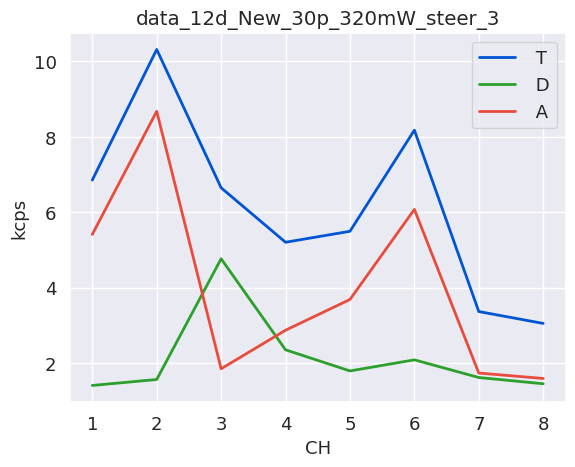

In [12]:
mch_plot_bg(d)

Let's take a look at the photon waiting times histograms and at the fitted background rates:

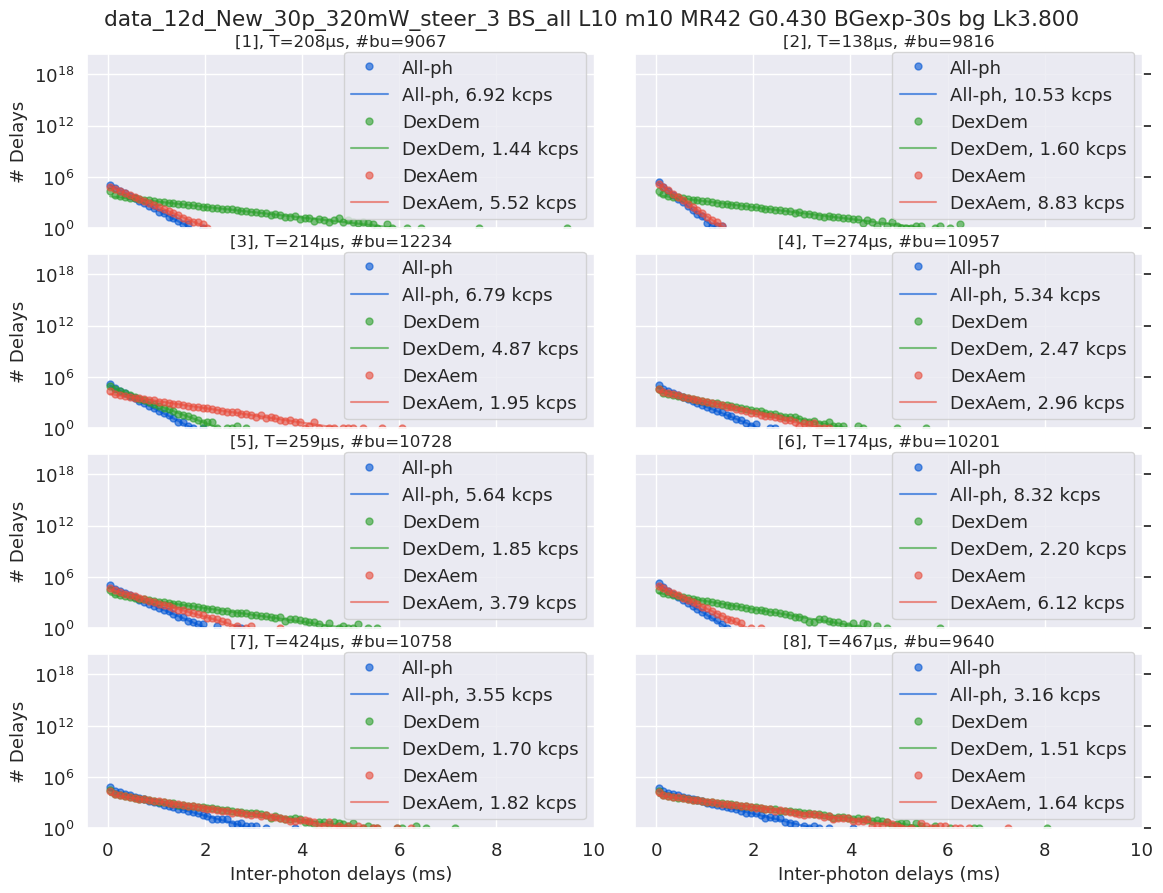

In [13]:
dplot(d, hist_bg);

Using `dplot` exactly in the same way as for the single-spot 
data has now generated 8 subplots, one for each channel.

Let's plot a timetrace for the background to see is there 
are significant variations during the measurement:

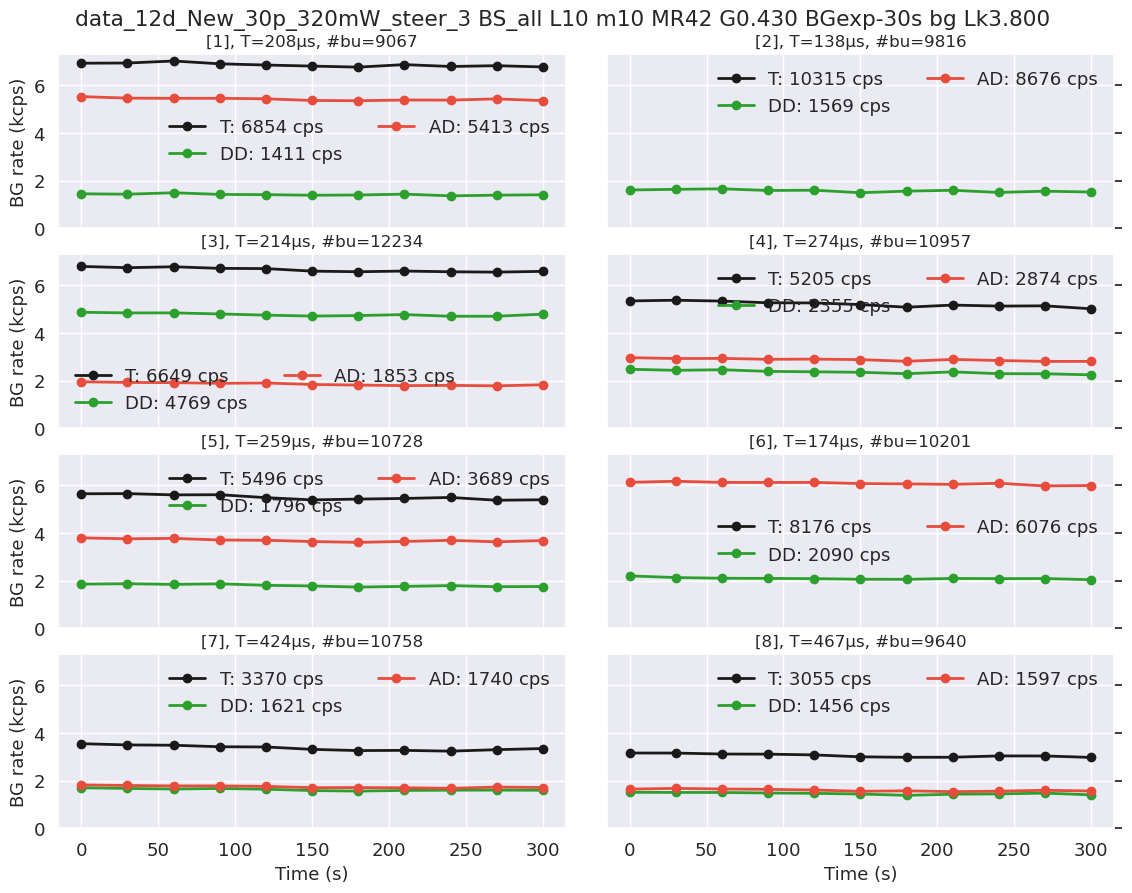

In [14]:
dplot(d, timetrace_bg);

We can look at the timetrace of the photon stream (binning):

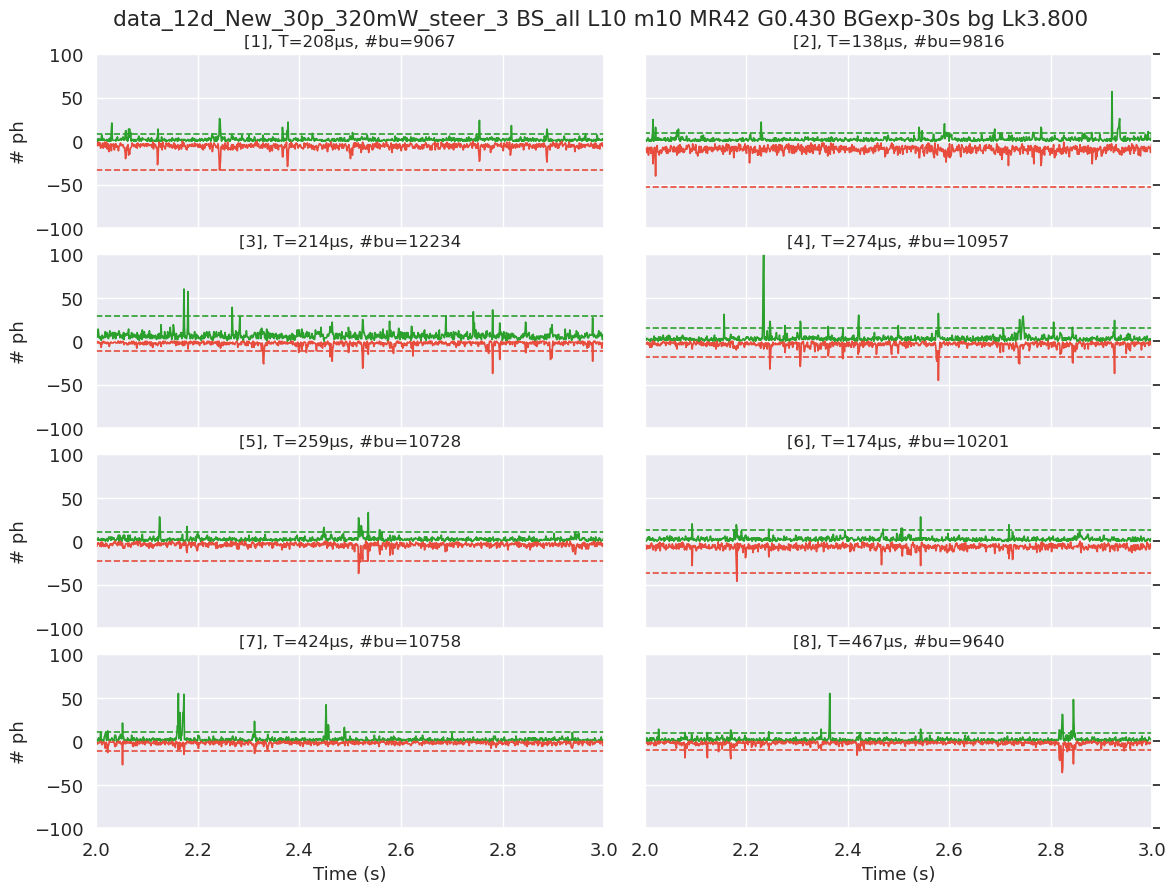

In [15]:
dplot(d, timetrace)
xlim(2, 3); ylim(-100, 100);

We can also open the same plot in an interactive window that allows scrolling (uncomment the following lines):

In [16]:
#%matplotlib qt

In [17]:
#dplot(d, timetrace, scroll=True);

In [18]:
#ylim(-100, 100)

In [19]:
#%matplotlib inline

## Burst selection and FRET

### Selecting bursts by burst size (`select_bursts.size`)

In [20]:
gamma = d.gamma
gamma

array(0.43)

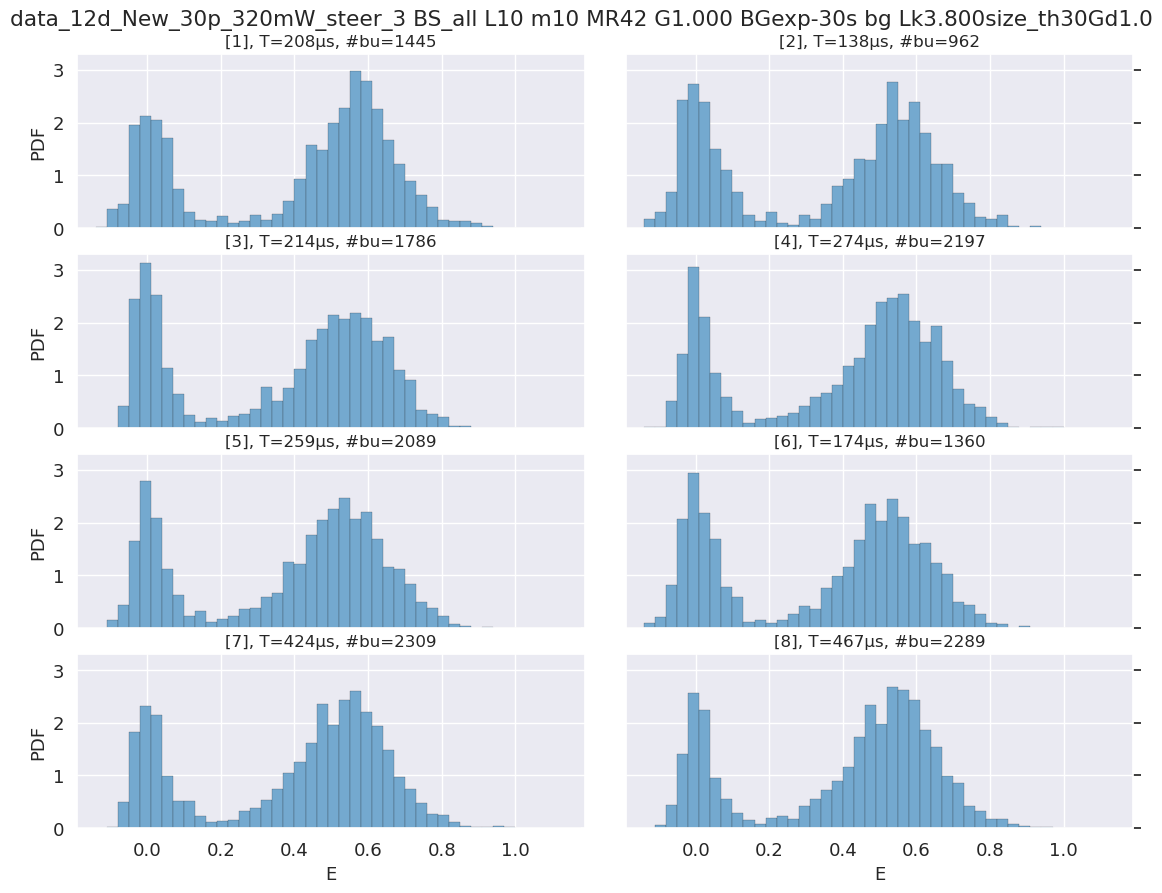

In [21]:
d.gamma = 1
ds = d.select_bursts(select_bursts.size, th1=30, gamma=1)
dplot(ds, hist_fret);

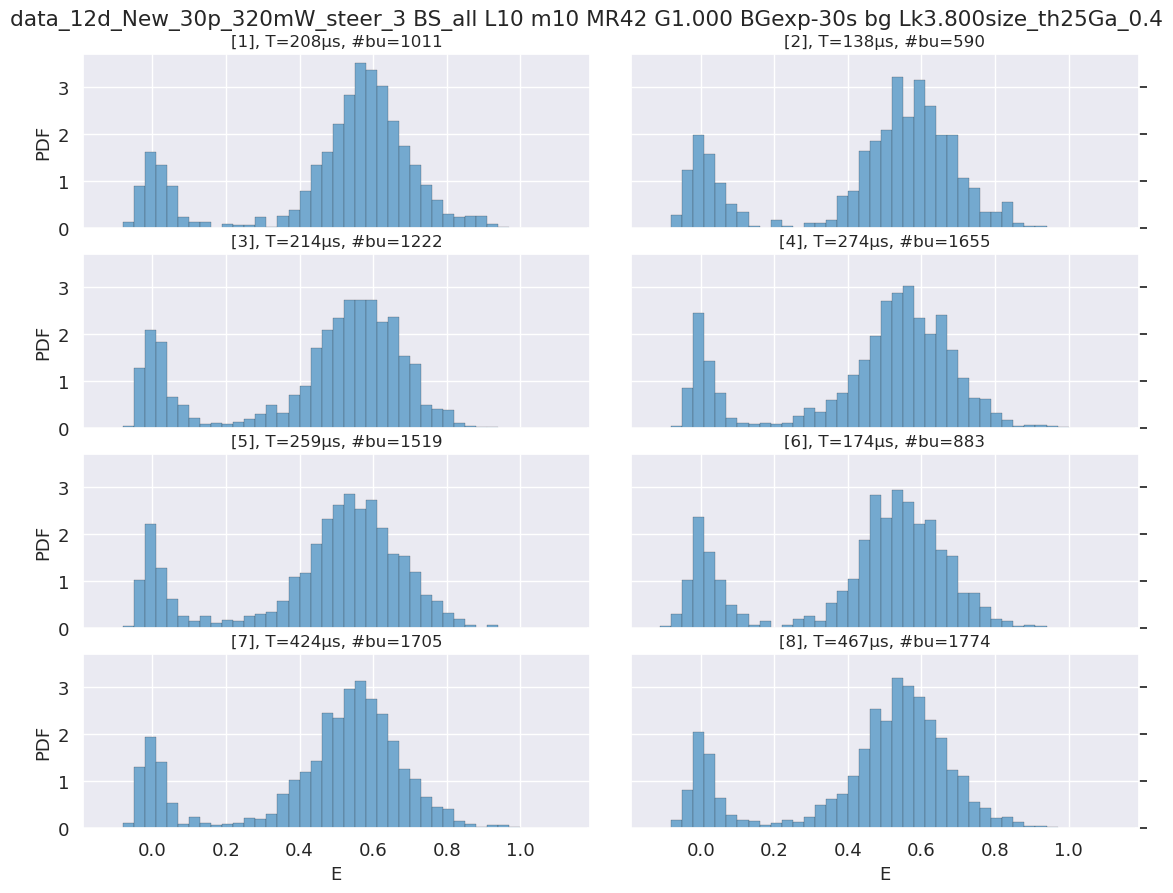

In [22]:
ds = d.select_bursts(select_bursts.size, th1=25, gamma=gamma, donor_ref=False)
dplot(ds, hist_fret);

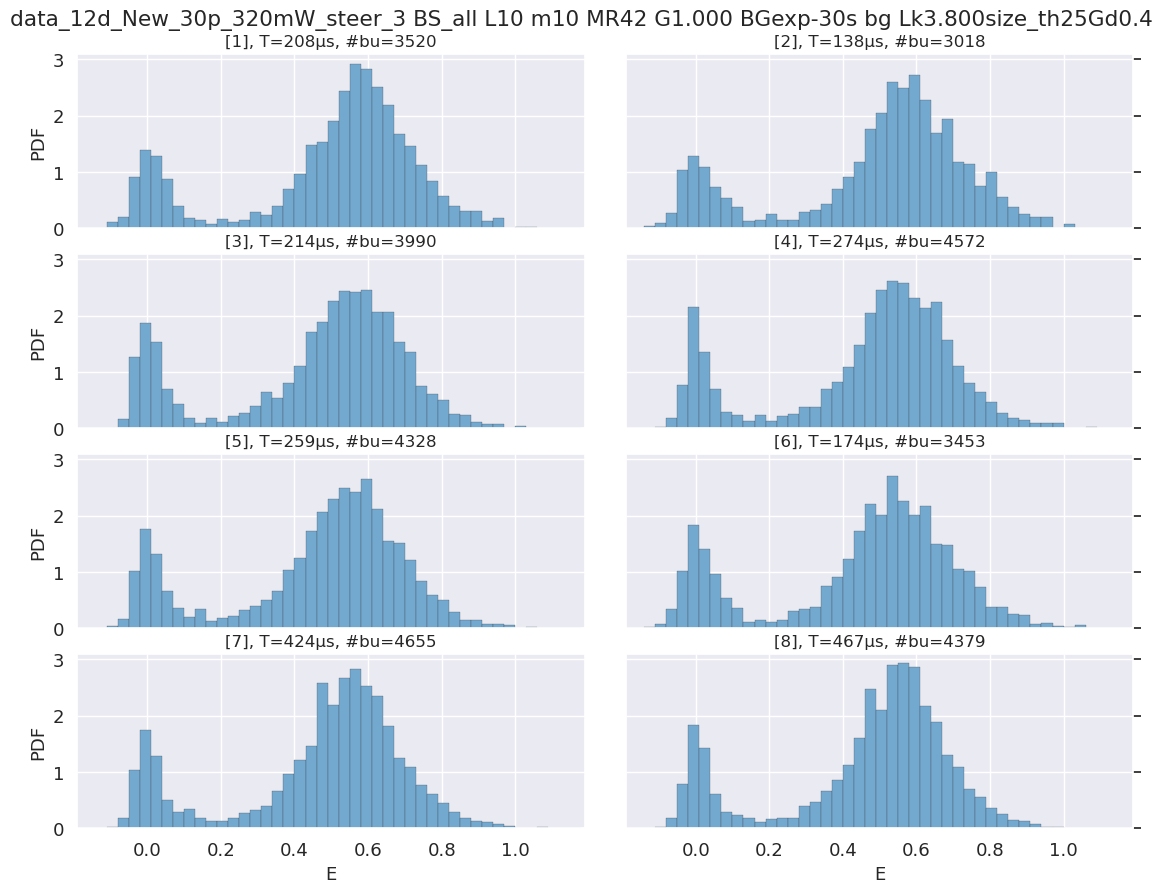

In [23]:
ds = d.select_bursts(select_bursts.size, th1=25, gamma=gamma)
dplot(ds, hist_fret, weights='size', gamma=gamma);

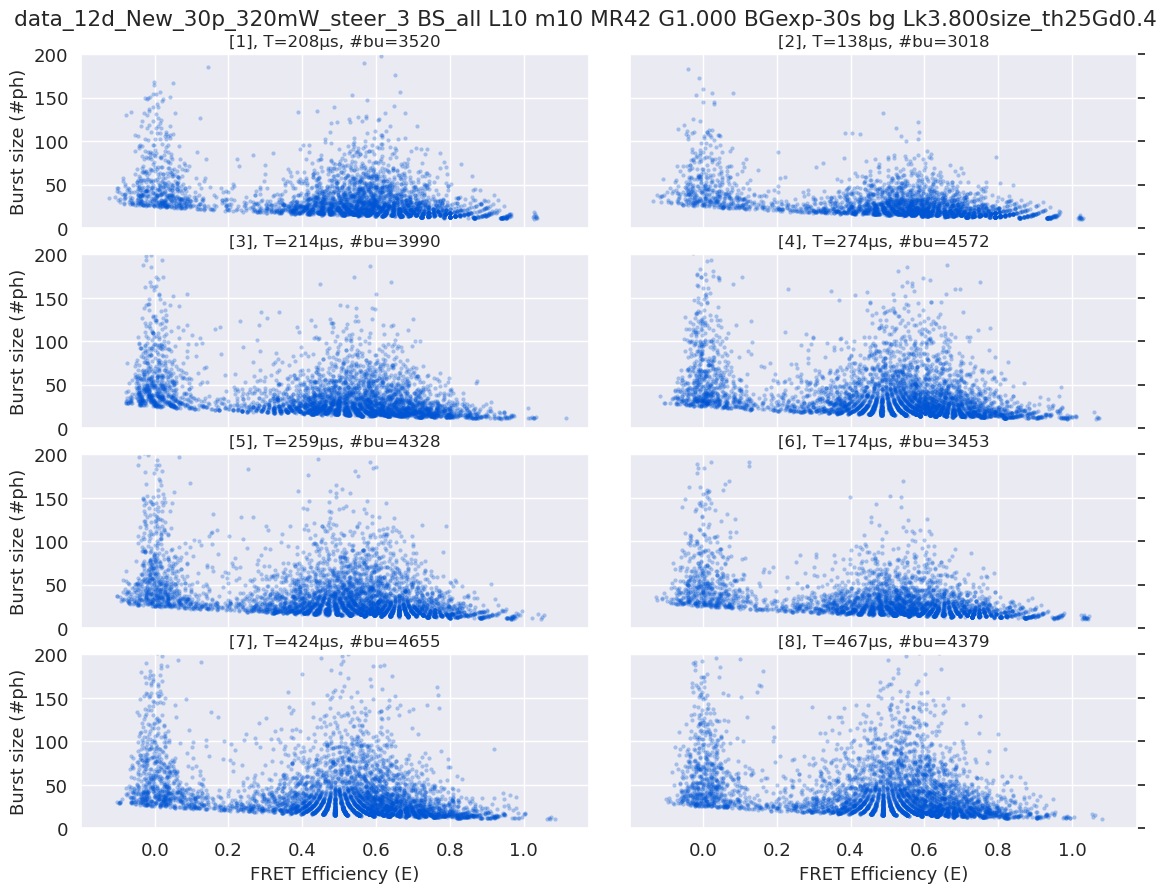

In [24]:
dplot(ds, scatter_fret_nd_na); ylim(0,200);

## FRET Fitting

### 2-Gaussian mixture

Let's fit the $E$ histogram with a 2-Gaussians model:

In [25]:
ds.gamma = 1.
bext.bursts_fitter(ds, weights=None)
ds.E_fitter.fit_histogram(mfit.factory_two_gaussians(), verbose=False)

The fitted parameters are stored in a pandas DataFrame:

In [26]:
ds.E_fitter.params

,p1_amplitude,p1_center,p1_fwhm,p1_height,p1_sigma,p2_amplitude,p2_center,p2_fwhm,p2_height,p2_sigma
0,0.161037,0.014736,0.129449,1.168678,0.054972,0.827205,0.587919,0.339242,2.290714,0.144063
1,0.154972,0.016518,0.153116,0.950830,0.065022,0.830273,0.592638,0.346325,2.252192,0.147070
2,0.172021,0.003633,0.101151,1.597639,0.042955,0.818251,0.562420,0.349216,2.201201,0.148298
3,0.151185,0.005764,0.096719,1.468473,0.041073,0.827219,0.565177,0.347431,2.236765,0.147540
4,0.155672,0.007181,0.104293,1.402241,0.044289,0.830064,0.558945,0.360475,2.163237,0.153080
5,0.169132,0.009137,0.126192,1.259111,0.053589,0.822268,0.561618,0.360905,2.140370,0.153262
6,0.152870,0.006242,0.113083,1.269961,0.048022,0.825790,0.559307,0.338339,2.292903,0.143679
7,0.154318,0.007727,0.097085,1.493249,0.041228,0.822816,0.556785,0.327245,2.362094,0.138968


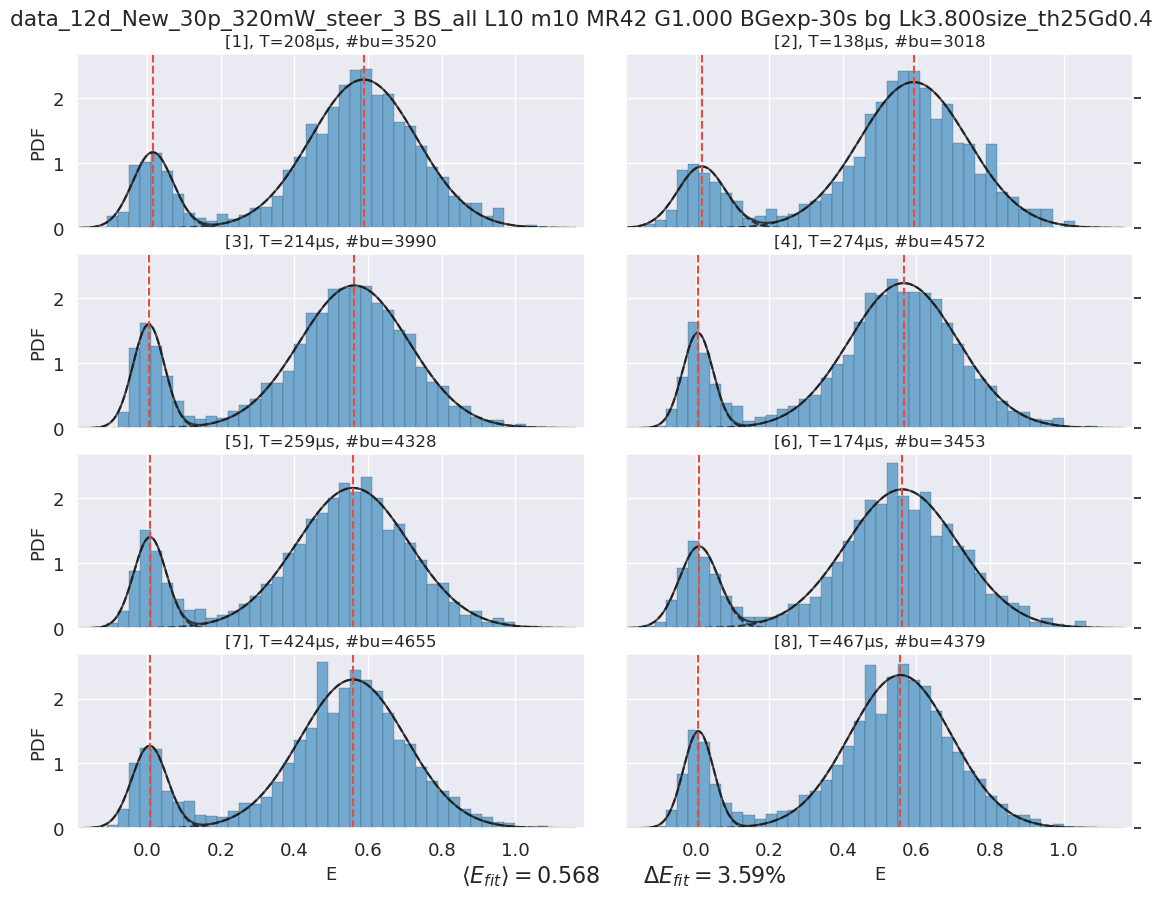

In [27]:
dplot(ds, hist_fret, weights=None, show_model=True,
      show_fit_stats=True, fit_from='p2_center');

### Weighted Expectation Maximization

The [expectation maximization](http://en.wikipedia.org/wiki/Expectation%E2%80%93maximization_algorithm) 
(EM) method is particularly suited to resolve population 
mixtures. Note that the EM algorithm does not fit the histogram 
but the $E$ distribution with no binning.

FRETBursts include a weighted version of the EM algorithm that 
can take into account the burst size.
The algorithm and benchmarks with the 2-Gaussian histogram fit 
are reported [here](http://nbviewer.ipython.org/github/tritemio/notebooks/blob/master/Mixture_Model_Fitting.ipynb).

You can find the EM algorithm in `fretbursts/fit/gaussian_fit.py` or typing:

`bl.two_gaussian_fit_EM??`


In [28]:
# bl.two_gaussian_fit_EM??

In [29]:
EM_results = ds.fit_E_two_gauss_EM(weights=None, gamma=1.)
EM_results

array([0.59034933, 0.59444601, 0.55839021, 0.56483764, 0.55495784,
       0.56629195, 0.56123016, 0.55426502])

The fitted parameters for each channel are stored in the `fit_E_res` attribute:

In [30]:
ds.fit_E_name, ds.fit_E_res

('two_gaussian_fit_EM',
 array([[0.01827052, 0.05425974, 0.59034933, 0.15131664, 0.16027376],
        [0.02447783, 0.06322272, 0.59444601, 0.15589896, 0.15287684],
        [0.00983909, 0.04251184, 0.55839021, 0.1552119 , 0.17085603],
        [0.01439759, 0.04672424, 0.56483764, 0.15681695, 0.15776544],
        [0.01588614, 0.04910262, 0.55495784, 0.15943355, 0.16035786],
        [0.01408361, 0.05310594, 0.56629195, 0.15905435, 0.16854415],
        [0.01827151, 0.05202847, 0.56123016, 0.15336741, 0.15783567],
        [0.0146511 , 0.04537418, 0.55426502, 0.14930368, 0.15880781]]))

The model function is stored in:

In [31]:
ds.fit_E_model

<function fretbursts.fit.gaussian_fitting.two_gauss_mix_pdf(x, p)>

Let's plot the histogram and the model with parameters from the EM fit:

E mean: 56.81%   E delta: 4.02%


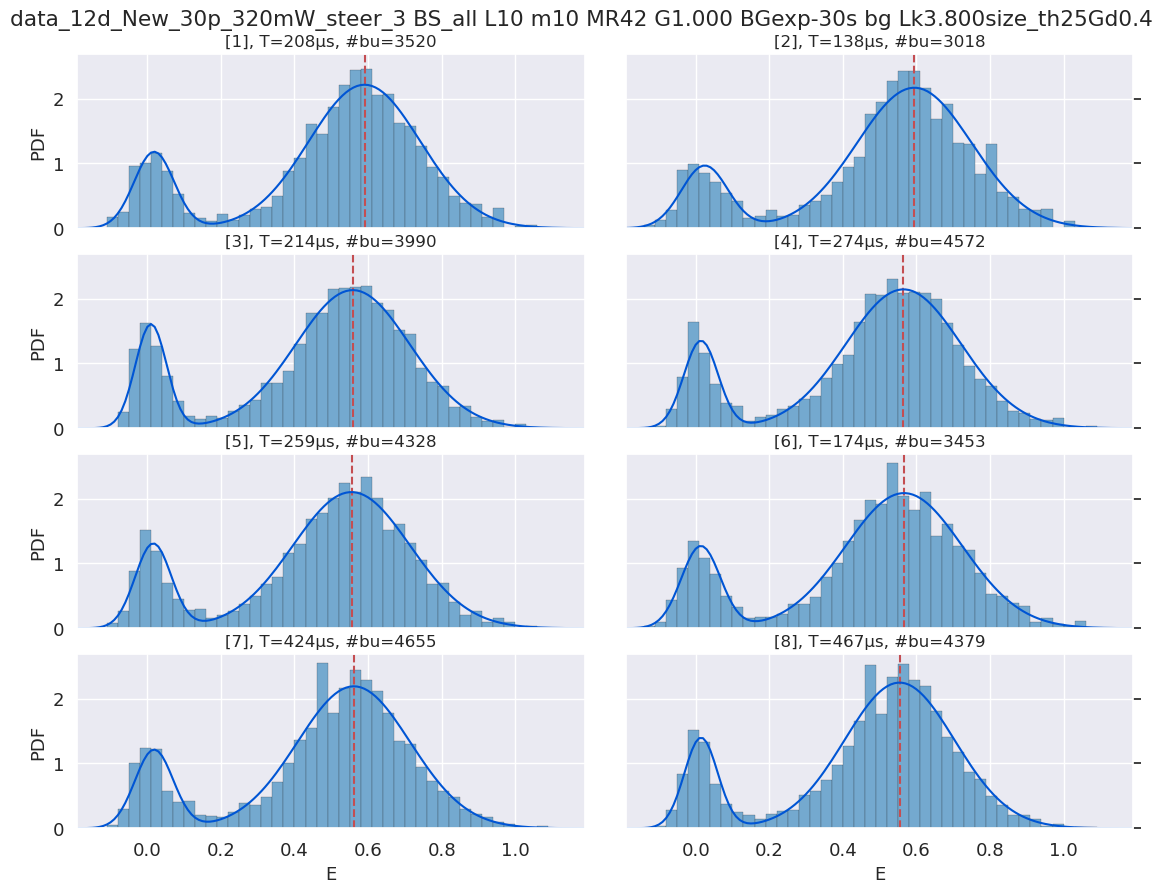

In [32]:
AX = dplot(ds, hist_fret, weights=None)

x = np.r_[-0.2: 1.2 : 0.01]
for ich, (ax, E_fit) in enumerate(zip(AX.ravel(), EM_results)):
    ax.axvline(E_fit, ls='--', color='r')
    ax.plot(x, ds.fit_E_model(x, ds.fit_E_res[ich]))

print('E mean: %.2f%%   E delta: %.2f%%' %\
      (EM_results.mean()*100, (EM_results.max() - EM_results.min())*100))

## Comparing 2-Gaussian and EM fit

To quickly compare the 2-Gaussians with the EM fit we convert the EM fit results in a DataFrame:

In [33]:
import pandas as pd

In [34]:
EM_results = pd.DataFrame(ds.fit_E_res, columns=['p1_center', 'p1_sigma', 'p2_center', 'p2_sigma', 'p1_amplitude'])
EM_results * 100

,p1_center,p1_sigma,p2_center,p2_sigma,p1_amplitude
0,1.827052,5.425974,59.034933,15.131664,16.027376
1,2.447783,6.322272,59.444601,15.589896,15.287684
2,0.983909,4.251184,55.839021,15.521190,17.085603
3,1.439759,4.672424,56.483764,15.681695,15.776544
4,1.588614,4.910262,55.495784,15.943355,16.035786
5,1.408361,5.310594,56.629195,15.905435,16.854415
6,1.827151,5.202847,56.123016,15.336741,15.783567
7,1.465110,4.537418,55.426502,14.930368,15.880781


In [35]:
ds.E_fitter.params * 100

,p1_amplitude,p1_center,p1_fwhm,p1_height,p1_sigma,p2_amplitude,p2_center,p2_fwhm,p2_height,p2_sigma
0,16.103730,1.473635,12.944926,116.867755,5.497204,82.720459,58.791861,33.924215,229.071433,14.406288
1,15.497249,1.651819,15.311570,95.082959,6.502225,83.027273,59.263750,34.632452,225.219162,14.707048
2,17.202083,0.363337,10.115099,159.763924,4.295487,81.825052,56.242039,34.921616,220.120130,14.829845
3,15.118486,0.576416,9.671862,146.847306,4.107262,82.721920,56.517696,34.743062,223.676477,14.754020
4,15.567179,0.718107,10.429298,140.224101,4.428915,83.006433,55.894461,36.047517,216.323749,15.307971
5,16.913240,0.913704,12.619168,125.911060,5.358868,82.226801,56.161799,36.090453,214.037008,15.326204
6,15.286970,0.624211,11.308341,126.996088,4.802210,82.578959,55.930694,33.833857,229.290311,14.367916
7,15.431760,0.772747,9.708476,149.324893,4.122810,82.281649,55.678519,32.724544,236.209408,13.896834


And we compute the difference between the two sets of parameters:

In [36]:
(ds.E_fitter.params - EM_results) * 100

,p1_amplitude,p1_center,p1_fwhm,p1_height,p1_sigma,p2_amplitude,p2_center,p2_fwhm,p2_height,p2_sigma
0,0.076354,-0.353417,NaN,NaN,0.071230,NaN,-0.243072,NaN,NaN,-0.725376
1,0.209565,-0.795964,NaN,NaN,0.179954,NaN,-0.180851,NaN,NaN,-0.882848
2,0.116480,-0.620572,NaN,NaN,0.044304,NaN,0.403018,NaN,NaN,-0.691345
3,-0.658058,-0.863343,NaN,NaN,-0.565162,NaN,0.033931,NaN,NaN,-0.927675
4,-0.468606,-0.870507,NaN,NaN,-0.481347,NaN,0.398677,NaN,NaN,-0.635384
5,0.058825,-0.494657,NaN,NaN,0.048273,NaN,-0.467396,NaN,NaN,-0.579230
6,-0.496596,-1.202940,NaN,NaN,-0.400637,NaN,-0.192322,NaN,NaN,-0.968824
7,-0.449021,-0.692363,NaN,NaN,-0.414608,NaN,0.252017,NaN,NaN,-1.033533


> **NOTE:** The EM method follows more the "asymmetry" of the 
> peaks because the center is a weighted mean of the bursts. 
> On the contrary the 2-Gaussians histogram fit tends to follows 
> more the peak position an less the "asymmetric" tails.  